# Cat Classifier

<a target="_blank" href="https://colab.research.google.com/github/LuisAngelMendozaVelasco/luisangelmendozavelasco.github.io/blob/master/_portfolio/Deep_Learning_Specialization/portfolio-1.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Run in Google Colab</a>

**Objective**: Train a Deep Neural Network and a Convolutional Neural Network for cat recognition.

A Deep Neural Network (DNN) is a type of neural network with multiple layers between the input and output layers. It is designed to learn complex patterns and relationships in data, and can be used for a wide range of tasks such as image classification, speech recognition, and natural language processing. DNNs can have different architectures, including fully connected layers, convolutional layers, and recurrent layers.

A [Convolutional Neural Network (CNN)](https://en.wikipedia.org/wiki/Convolutional_neural_network) is a type of DNN that is specifically designed for image and video processing tasks. It uses convolutional layers to extract features from input data, and is particularly useful for tasks such as image classification, object detection, and image segmentation. CNNs are designed to take advantage of the spatial hierarchies and local feature extraction in images, and are often used in computer vision applications.

## Import libraries

In [1]:
import numpy as np
import h5py
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from keras import Sequential, Input, layers, optimizers, callbacks
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

2025-01-02 15:30:03.479794: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735853403.492900  205901 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735853403.496821  205901 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-02 15:30:03.509589: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Download the dataset

In [2]:
%%bash

wget -nc --progress=bar:force:noscroll https://raw.githubusercontent.com/LuisAngelMendozaVelasco/Deep_Learning_Specialization/main/Neural_Networks_and_Deep_Learning/Week2/Labs/datasets/train_catvnoncat.h5 -P /tmp
wget -nc --progress=bar:force:noscroll https://raw.githubusercontent.com/LuisAngelMendozaVelasco/Deep_Learning_Specialization/main/Neural_Networks_and_Deep_Learning/Week2/Labs/datasets/test_catvnoncat.h5 -P /tmp

File '/tmp/train_catvnoncat.h5' already there; not retrieving.

File '/tmp/test_catvnoncat.h5' already there; not retrieving.



## Load the dataset

In [ ]:
dataset_train = h5py.File('/tmp/train_catvnoncat.h5', "r")
X_train = dataset_train["train_set_x"][:]
y_train = dataset_train["train_set_y"][:]

dataset_test = h5py.File('/tmp/test_catvnoncat.h5', "r")
X = dataset_test["test_set_x"][:]
y = dataset_test["test_set_y"][:]
X_test, X_validation, y_test, y_validation = train_test_split(X, y, test_size=0.5, random_state=0)

ds_train = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(32)
ds_validation = tf.data.Dataset.from_tensor_slices((X_validation, y_validation)).batch(32)
classes = dataset_train["list_classes"][:].astype(str)

I0000 00:00:1735851290.088879   60931 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1430 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


In [4]:
print("Number of training samples:", X_train.shape[0])
print("Number of validation samples:", X_validation.shape[0])
print("Number of test samples:", X_test.shape[0])
print("Each image has a shape of", X_train.shape[1:])

Number of training samples: 209
Number of validation samples: 25
Number of test samples: 25
Each image has a shape of (64, 64, 3)


## Visualize the dataset

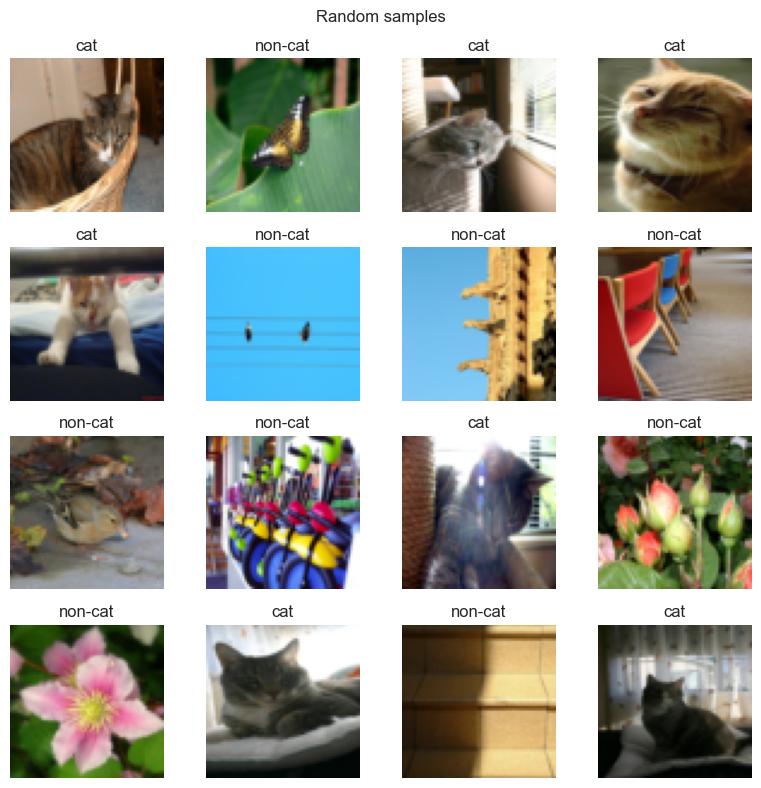

In [5]:
indexes = np.random.choice(range(0, X_train.shape[0]), size=16, replace=False)
samples = zip(X_train[indexes], y_train[indexes])

fig, axs = plt.subplots(4, 4, figsize=(8, 8))
fig.suptitle('Random samples')

for ax, sample in zip(axs.flatten(), samples):
    ax.imshow(sample[0])
    ax.set_title(classes[sample[1]])
    ax.axis("off")

plt.tight_layout()
plt.show()

## Visualize the class distribution

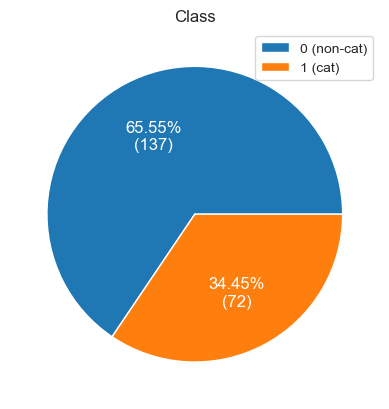

In [6]:
labels, sizes = np.unique(y_train, return_counts=True)

fig, ax = plt.subplots()
ax.pie(sizes, textprops={'color': "w", 'fontsize': '12'}, autopct=lambda pct: "{:.2f}%\n({:d})".format(pct, round(pct/100 * sum(sizes))))
ax.legend(["1 (cat)" if label else "0 (non-cat)" for label in labels])
ax.set_title("Class")
plt.show()

## Build a Deep Neural Network

In [7]:
model_DNN = Sequential([Input(shape=(64, 64, 3)),
                        # Rescale
                        layers.Rescaling(scale=1 / 255),
                        # Data augmentation
                        layers.RandomFlip(mode="horizontal"),
                        layers.RandomTranslation(height_factor=0.2, width_factor=0.2, fill_mode="nearest"),
                        layers.RandomRotation(factor=0.2, fill_mode="nearest"),
                        layers.RandomZoom(height_factor=0.2, width_factor=0.2, fill_mode="nearest"),
                        # Deep layers
                        layers.Flatten(),
                        layers.BatchNormalization(),
                        layers.Dropout(0.5),
                        layers.Dense(32, activation="relu"),
                        layers.BatchNormalization(),
                        layers.Dropout(0.5),
                        layers.Dense(64, activation="relu"),
                        layers.BatchNormalization(),
                        layers.Dropout(0.5),
                        layers.Dense(128, activation="relu"),
                        layers.BatchNormalization(),
                        layers.Dense(1, activation="sigmoid")])

model_DNN.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip (RandomFlip)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_translation              │ (None, 64, 64, 3)      │             0 │
│ (RandomTranslation)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, 64, 64, 3)      │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom (RandomZoom)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12288)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 12288)          │        49,152 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12288)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │       393,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 453,857 (1.73 MB)

 Trainable params: 428,833 (1.64 MB)

 Non-trainable params: 25,024 (97.75 KB)

## Create a custom callback

In [8]:
class CustomVerbose(callbacks.Callback):
    def __init__(self, epochs_to_show):
        self.epochs_to_show = epochs_to_show

    def on_epoch_begin(self, epoch, logs=None):
        if epoch in self.epochs_to_show:
            self.epoch_start_time = datetime.now()

    def on_epoch_end(self, epoch, logs=None):
        if epoch in self.epochs_to_show:
            self.epoch_stop_time = datetime.now()
            print(f"Epoch {epoch+1}/{self.epochs_to_show[-1] + 1}")
            print(f"\telapsed time: {(self.epoch_stop_time - self.epoch_start_time).total_seconds():.3f}s - accuracy: {logs['binary_accuracy']:.4f} - loss: {logs['loss']:.4f} - val_accuracy: {logs['val_binary_accuracy']:.4f} - val_loss: {logs['val_loss']:.4f}")

## Compile and train the model

In [9]:
model_DNN.compile(optimizer="adam", loss='binary_crossentropy', metrics=['binary_accuracy'])

epochs = 1000
epochs_to_show = [0] + [i for i in range(int(epochs/10)-1, epochs, int(epochs/10))]
custom_verbose = CustomVerbose(epochs_to_show)
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=int(epochs/10), verbose=1)
history_DNN = model_DNN.fit(ds_train, epochs=epochs, verbose=0, validation_data=ds_validation, callbacks=[custom_verbose, early_stopping])

Epoch 1/1000
	elapsed time: 4.370s - accuracy: 0.5215 - loss: 0.9016 - val_accuracy: 0.3600 - val_loss: 1.1929
Epoch 100/1000
	elapsed time: 0.046s - accuracy: 0.6938 - loss: 0.5545 - val_accuracy: 0.5200 - val_loss: 0.7159
Epoch 200/1000
	elapsed time: 0.056s - accuracy: 0.6794 - loss: 0.5162 - val_accuracy: 0.6800 - val_loss: 0.6426
Epoch 300/1000
	elapsed time: 0.053s - accuracy: 0.7177 - loss: 0.4660 - val_accuracy: 0.6800 - val_loss: 0.5633
Epoch 400/1000
	elapsed time: 0.051s - accuracy: 0.7464 - loss: 0.4551 - val_accuracy: 0.6400 - val_loss: 0.5554
Epoch 449: early stopping


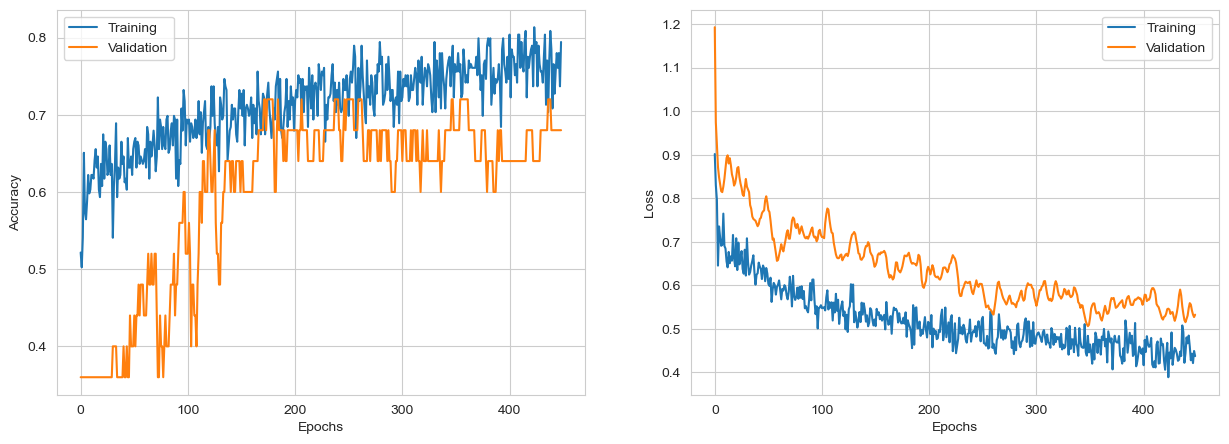

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(history_DNN.history['binary_accuracy'])
ax1.plot(history_DNN.history['val_binary_accuracy'])
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Accuracy")
ax1.legend(["Training", "Validation"])

ax2.plot(history_DNN.history['loss'])
ax2.plot(history_DNN.history['val_loss'])
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Loss")
ax2.legend(["Training", "Validation"])

plt.show()

## Evaluate the model

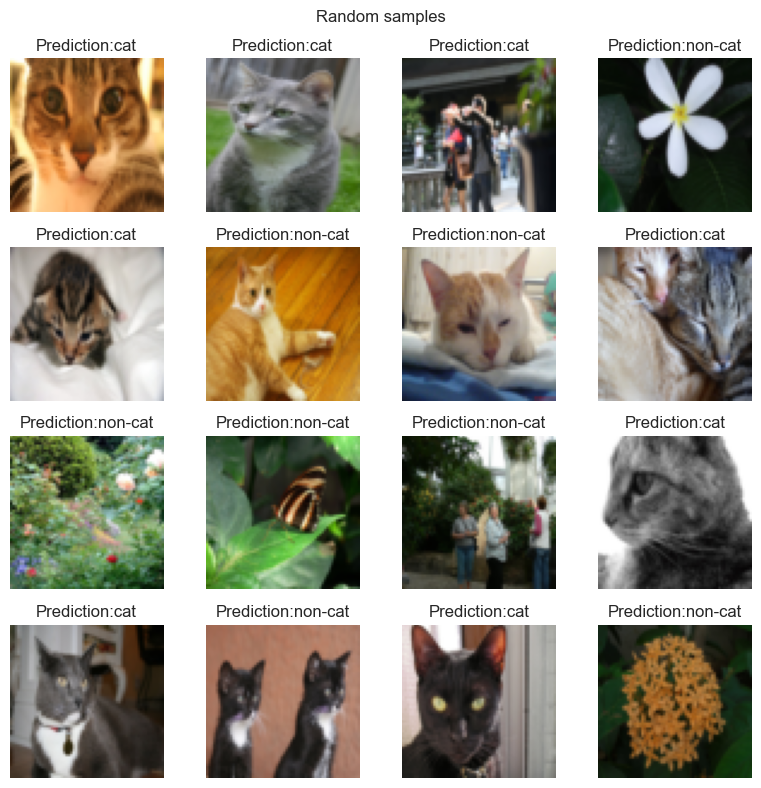

In [11]:
indexes = np.random.choice(range(0, X_test.shape[0]), size=16, replace=False)

fig, axs = plt.subplots(4, 4, figsize=(8, 8))
fig.suptitle('Random samples')

for image, ax in zip(X_test[indexes], axs.flatten()):
    prediction_proba = model_DNN.predict(np.expand_dims(image, axis=0), verbose=0)
    ax.imshow(image)
    ax.set_title("Prediction:" + classes[int(prediction_proba.squeeze().round())])
    ax.axis("off")

plt.tight_layout()
plt.show()

              precision    recall  f1-score   support

           0     0.5455    0.7500    0.6316         8
           1     0.8571    0.7059    0.7742        17

    accuracy                         0.7200        25
   macro avg     0.7013    0.7279    0.7029        25
weighted avg     0.7574    0.7200    0.7286        25



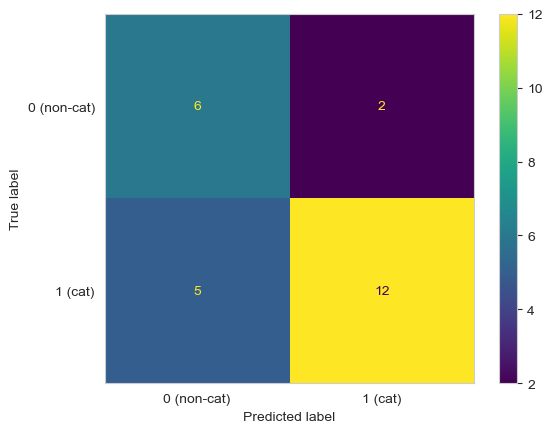

In [12]:
y_pred = []

for image in X_test:
    prediction_proba = model_DNN.predict(np.expand_dims(image, axis=0), verbose=0)
    y_pred.append(int(prediction_proba.squeeze().round()))

print(classification_report(y_test, y_pred, digits=4))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=["0 (non-cat)", "1 (cat)"])
plt.grid(False)
plt.show()

## Build a Convolutional Neural Network

In [20]:
model_CNN = Sequential([Input(shape=(64, 64, 3)),
                        # Rescale
                        layers.Rescaling(scale=1 / 255),
                        # Data augmentation
                        layers.RandomFlip(mode="horizontal"),
                        layers.RandomTranslation(height_factor=0.2, width_factor=0.2, fill_mode="nearest"),
                        layers.RandomRotation(factor=0.2, fill_mode="nearest"),
                        layers.RandomZoom(height_factor=0.2, width_factor=0.2, fill_mode="nearest"),
                        # Convolutional layers
                        layers.Conv2D(16, 3, padding='same', activation='relu'),
                        layers.MaxPooling2D(),
                        layers.Conv2D(32, 3, padding='same', activation='relu'),
                        layers.MaxPooling2D(),
                        layers.Conv2D(64, 3, padding='same', activation='relu'),
                        layers.MaxPooling2D(),
                        # Deep layers
                        layers.Flatten(),
                        layers.BatchNormalization(),
                        layers.Dropout(0.5),
                        layers.Dense(128, activation="relu"),
                        layers.BatchNormalization(),
                        layers.Dense(1, activation="sigmoid")])

model_CNN.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)         │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_3 (RandomFlip)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_translation_3            │ (None, 64, 64, 3)      │             0 │
│ (RandomTranslation)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_3               │ (None, 64, 64, 3)      │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_3 (RandomZoom)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 64, 64, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 4096)           │        16,384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 565,025 (2.16 MB)

 Trainable params: 556,577 (2.12 MB)

 Non-trainable params: 8,448 (33.00 KB)

## Compile and train the model

In [21]:
model_CNN.compile(optimizer=optimizers.Adam(1e-5), loss='binary_crossentropy', metrics=['binary_accuracy'])

epochs = 1000
epochs_to_show = [0] + [i for i in range(int(epochs/10)-1, epochs, int(epochs/10))]
custom_verbose = CustomVerbose(epochs_to_show)
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=epochs/10, verbose=1)
history_CNN = model_CNN.fit(ds_train, epochs=epochs, verbose=0, validation_data=ds_validation, callbacks=[custom_verbose, early_stopping])

Epoch 1/1000
	elapsed time: 2.571s - accuracy: 0.5215 - loss: 0.8841 - val_accuracy: 0.3200 - val_loss: 0.7039
Epoch 100/1000
	elapsed time: 0.059s - accuracy: 0.6986 - loss: 0.5975 - val_accuracy: 0.7600 - val_loss: 0.5993
Epoch 200/1000
	elapsed time: 0.056s - accuracy: 0.7512 - loss: 0.4966 - val_accuracy: 0.7200 - val_loss: 0.5427
Epoch 300/1000
	elapsed time: 0.067s - accuracy: 0.7799 - loss: 0.4475 - val_accuracy: 0.7600 - val_loss: 0.5031
Epoch 400/1000
	elapsed time: 0.063s - accuracy: 0.8278 - loss: 0.3617 - val_accuracy: 0.6800 - val_loss: 0.4953
Epoch 403: early stopping


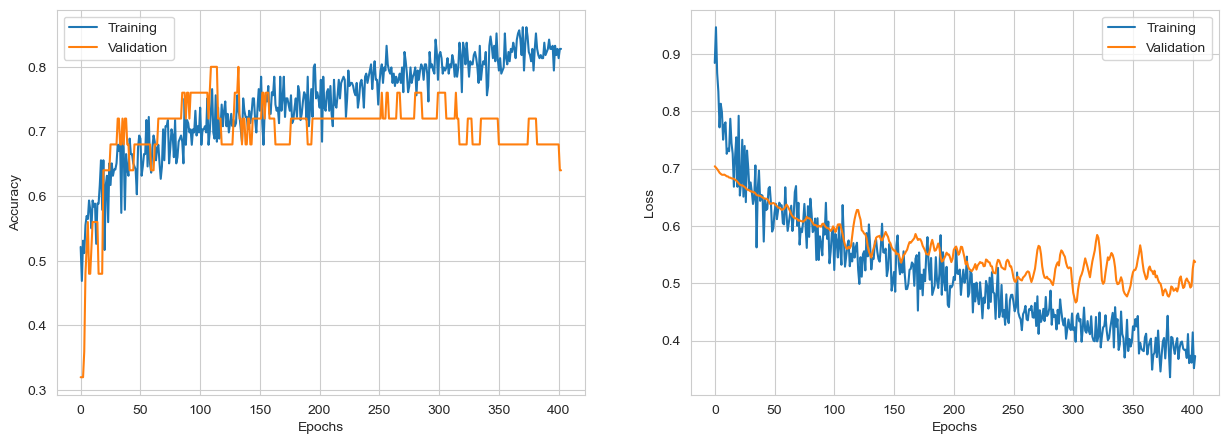

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(history_CNN.history['binary_accuracy'])
ax1.plot(history_CNN.history['val_binary_accuracy'])
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Accuracy")
ax1.legend(["Training", "Validation"])

ax2.plot(history_CNN.history['loss'])
ax2.plot(history_CNN.history['val_loss'])
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Loss")
ax2.legend(["Training", "Validation"])

plt.show()

## Evaluate the model

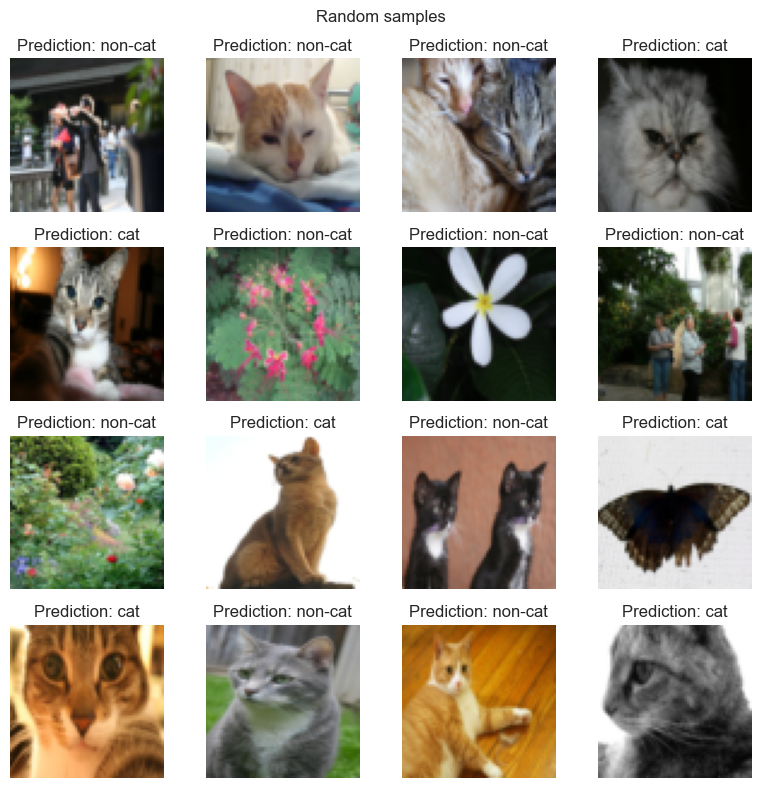

In [23]:
indexes = np.random.choice(range(0, X_test.shape[0]), size=16, replace=False)

fig, axs = plt.subplots(4, 4, figsize=(8, 8))
fig.suptitle('Random samples')

for image, ax in zip(X_test[indexes], axs.flatten()):
    prediction_proba = model_CNN.predict(np.expand_dims(image, axis=0), verbose=0)
    ax.imshow(image)
    ax.set_title("Prediction: " + classes[int(prediction_proba.squeeze().round())])
    ax.axis("off")

plt.tight_layout()
plt.show()

              precision    recall  f1-score   support

           0     0.4667    0.8750    0.6087         8
           1     0.9000    0.5294    0.6667        17

    accuracy                         0.6400        25
   macro avg     0.6833    0.7022    0.6377        25
weighted avg     0.7613    0.6400    0.6481        25



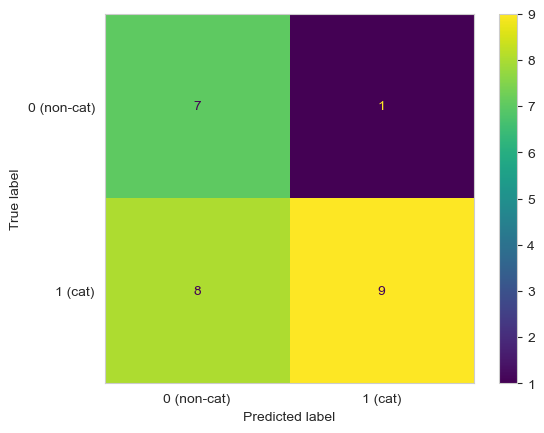

In [24]:
y_pred = []

for image in X_test:
    prediction_proba = model_CNN.predict(np.expand_dims(image, axis=0), verbose=0)
    y_pred.append(int(prediction_proba.squeeze().round()))

print(classification_report(y_test, y_pred, digits=4))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=["0 (non-cat)", "1 (cat)"])
plt.grid(False)
plt.show()